<a href="https://colab.research.google.com/github/piyushak22/Emotion-Recognition-Using-Physiological-Signals-/blob/main/PreprocessingEDA%2BHR_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load the EDA data
eda_data = pd.read_csv('/content/sample_data/E4_EDA.csv')
eda_data['timestamp'] = pd.to_datetime(eda_data['timestamp'], unit='ms')
eda_values = eda_data['value'].values

In [ ]:
# Define filter functions
def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

In [ ]:
def butter_highpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

In [ ]:
def lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [ ]:
def highpass_filter(data, cutoff, fs, order=4):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [ ]:
# Filtering
fs = 4  # Sampling frequency (4 Hz for EDA data)
low_cutoff = 1.0  # Low-pass filter cutoff frequency (Hz)
high_cutoff = 0.01  # High-pass filter cutoff frequency (Hz)

In [ ]:
eda_filtered = lowpass_filter(eda_values, low_cutoff, fs)
eda_filtered = highpass_filter(eda_filtered, high_cutoff, fs)

In [ ]:
# Detrending
eda_detrended = detrend(eda_filtered)

In [ ]:
# Artifact Removal
# 1. Detect and remove large motion artifacts using a threshold (e.g., changes greater than 3 standard deviations)
eda_zscores = zscore(eda_detrended)
artifact_indices = np.where(np.abs(eda_zscores) > 3)[0]
eda_cleaned = np.delete(eda_detrended, artifact_indices)


In [ ]:
# 2. Interpolate to fill gaps left by artifact removal
eda_interpolated = np.interp(np.arange(len(eda_detrended)), np.setdiff1d(np.arange(len(eda_detrended)), artifact_indices), eda_cleaned)


In [ ]:
# Z-Score Normalization after artifact removal
eda_normalized = (eda_interpolated - np.mean(eda_interpolated)) / np.std(eda_interpolated)

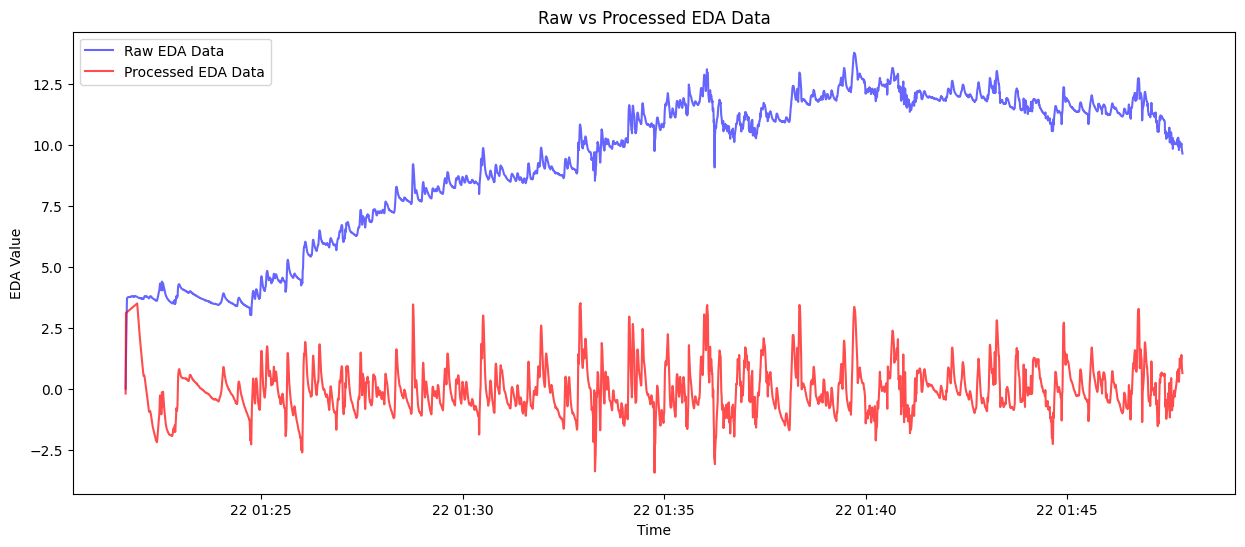

In [ ]:
# Plot Raw and Processed EDA Data
plt.figure(figsize=(15, 6))
plt.plot(eda_data['timestamp'], eda_values, label='Raw EDA Data', color='blue', alpha=0.6)
plt.plot(eda_data['timestamp'], eda_normalized, label='Processed EDA Data', color='red', alpha=0.7)
plt.title('Raw vs Processed EDA Data')
plt.xlabel('Time')
plt.ylabel('EDA Value')
plt.legend()
plt.show()

In [ ]:
# Perform Statistical Analysis on Processed Data
mean_eda = np.mean(eda_normalized)
std_eda = np.std(eda_normalized)
min_eda = np.min(eda_normalized)
max_eda = np.max(eda_normalized)
kurtosis_eda = kurtosis(eda_normalized)
skewness_eda = skew(eda_normalized)

In [ ]:
print("Statistical Analysis of Processed EDA Data:")
print(f"Mean: {mean_eda}")
print(f"Standard Deviation: {std_eda}")
print(f"Min Value: {min_eda}")
print(f"Max Value: {max_eda}")
print(f"Kurtosis: {kurtosis_eda}")
print(f"Skewness: {skewness_eda}")

Statistical Analysis of Processed EDA Data:
Mean: 4.51353175010386e-18
Standard Deviation: 1.0
Min Value: -3.449458956326034
Max Value: 3.5086231341524217
Kurtosis: 1.5226341121111027
Skewness: 0.8175561794604848


In [ ]:
# Trough-to-Peak Feature Extraction
def extract_trough_to_peak_features(eda_signal, fs):
    # Number of SCRs
    number_of_scrs = np.sum(eda_signal > np.mean(eda_signal) + 1 * np.std(eda_signal))
    summed_magnitude_of_scrs = np.sum(eda_signal[eda_signal > np.mean(eda_signal) + 1 * np.std(eda_signal)])
    summed_area_under_scrs = np.sum(eda_signal[eda_signal > np.mean(eda_signal) + 1 * np.std(eda_signal)])

    return {
        'Number_of_SCRs': number_of_scrs,
        'Summed_Magnitude_of_SCRs': summed_magnitude_of_scrs,
        'Summed_Area_Under_SCRs': summed_area_under_scrs
    }

In [ ]:
# Decomposition-Based Feature Extraction
def extract_decomposition_features(eda_signal):
    mean_tonic_level = np.mean(eda_signal)
    std_tonic_level = np.std(eda_signal)
    mean_phasic_activity = np.mean(np.diff(eda_signal))  # Using difference as a proxy for phasic
    number_of_responses = np.sum(np.diff(eda_signal) > 0)

    return {
        'Mean_Tonic_Level': mean_tonic_level,
        'Std_Tonic_Level': std_tonic_level,
        'Mean_Phasic_Activity': mean_phasic_activity,
        'Number_of_Responses': number_of_responses
    }

In [ ]:
# Additional Statistical Features
def extract_statistical_features(eda_signal):
    skewness = skew(eda_signal)
    kurtosis_value = kurtosis(eda_signal)

    return {
        'Skewness': skewness,
        'Kurtosis': kurtosis_value
    }

In [ ]:
# Segment the data into 5-second windows and extract features
window_size = 5 * fs  # 5 seconds worth of data

In [ ]:
features_list = []
for start in range(0, len(eda_normalized), window_size):
    end = start + window_size
    if end > len(eda_normalized):
        break
    window_eda = eda_normalized[start:end]
    features = {}
    features.update(extract_trough_to_peak_features(window_eda, fs))
    features.update(extract_decomposition_features(window_eda))
    features.update(extract_statistical_features(window_eda))
    features_list.append(features)

In [ ]:
# Convert to DataFrame
features_df = pd.DataFrame(features_list)

In [ ]:
# Load the synchronized data
sync_data = pd.read_csv('/content/sample_data/synchronized_data.csv')

In [ ]:
# Start time for EDA data in milliseconds
start_time = 1548120820000
start_time = pd.to_datetime(start_time, unit='ms')

In [ ]:
# Calculate the timestamp for each 5-second interval
features_df['timestamp'] = pd.date_range(start=start_time, periods=len(features_df), freq='5S')

In [ ]:
# Convert timestamp to seconds since the start time
features_df['seconds'] = (features_df['timestamp'] - start_time).dt.total_seconds()

In [ ]:
# Synchronize the data based on the 'seconds' column
synchronized_data = pd.merge(features_df, sync_data, on='seconds', how='inner')

In [ ]:
# Save the final synchronized data
synchronized_data.to_csv('synchronized_eda_features_final.csv', index=False)

In [ ]:
# Load the EDA data
eda_data = pd.read_csv('/content/sample_data/E4_EDA4.csv')
eda_data['timestamp'] = pd.to_datetime(eda_data['timestamp'], unit='ms')
eda_values = eda_data['value'].values

In [ ]:
# Define filter functions
def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_highpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def highpass_filter(data, cutoff, fs, order=4):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [ ]:
# Filtering
fs = 4  # Sampling frequency (4 Hz for EDA data)
low_cutoff = 1.0  # Low-pass filter cutoff frequency (Hz)
high_cutoff = 0.01  # High-pass filter cutoff frequency (Hz)

In [ ]:
eda_filtered = lowpass_filter(eda_values, low_cutoff, fs)
eda_filtered = highpass_filter(eda_filtered, high_cutoff, fs)

In [ ]:
# Detrending
eda_detrended = detrend(eda_filtered)

In [ ]:
# Artifact Removal
eda_zscores = np.abs((eda_detrended - np.mean(eda_detrended)) / np.std(eda_detrended))
artifact_indices = np.where(eda_zscores > 3)[0]
eda_cleaned = np.delete(eda_detrended, artifact_indices)

In [ ]:
# Interpolate to fill gaps left by artifact removal
eda_interpolated = np.interp(np.arange(len(eda_detrended)), np.setdiff1d(np.arange(len(eda_detrended)), artifact_indices), eda_cleaned)

In [ ]:
# Z-Score Normalization after artifact removal
eda_normalized = (eda_interpolated - np.mean(eda_interpolated)) / np.std(eda_interpolated)

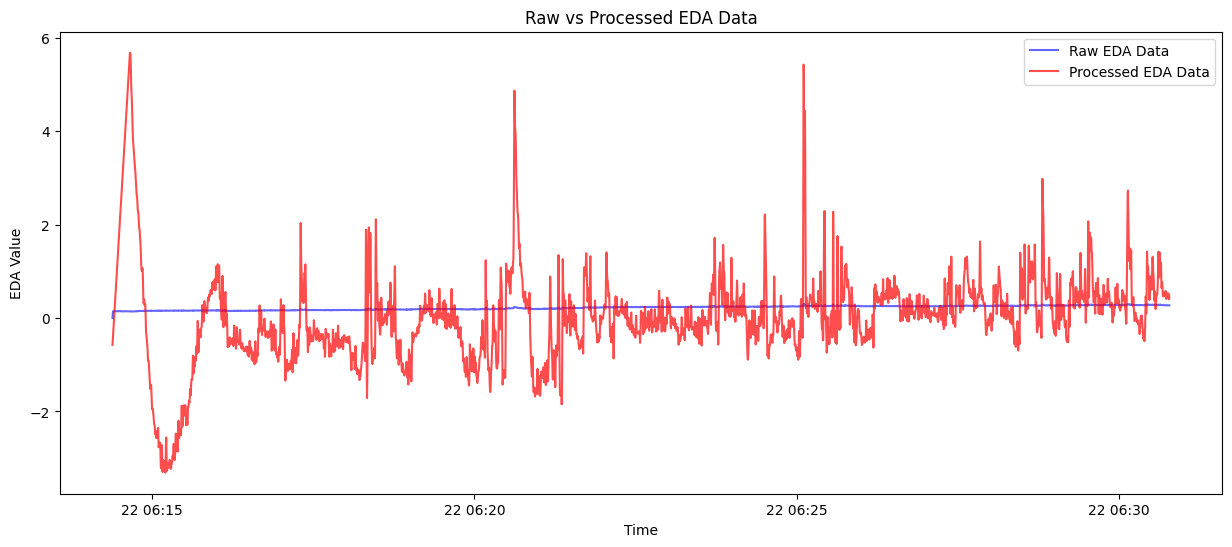

In [ ]:
# Plot Raw and Processed EDA Data
plt.figure(figsize=(15, 6))
plt.plot(eda_data['timestamp'], eda_values, label='Raw EDA Data', color='blue', alpha=0.6)
plt.plot(eda_data['timestamp'], eda_normalized, label='Processed EDA Data', color='red', alpha=0.7)
plt.title('Raw vs Processed EDA Data')
plt.xlabel('Time')
plt.ylabel('EDA Value')
plt.legend()
plt.show()

In [ ]:
# Trough-to-Peak Feature Extraction
def extract_trough_to_peak_features(eda_signal, fs):
    # Number of SCRs
    number_of_scrs = np.sum(eda_signal > np.mean(eda_signal) + 1 * np.std(eda_signal))
    summed_magnitude_of_scrs = np.sum(eda_signal[eda_signal > np.mean(eda_signal) + 1 * np.std(eda_signal)])
    summed_area_under_scrs = np.sum(eda_signal[eda_signal > np.mean(eda_signal) + 1 * np.std(eda_signal)])

    return {
        'Number_of_SCRs': number_of_scrs,
        'Summed_Magnitude_of_SCRs': summed_magnitude_of_scrs,
        'Summed_Area_Under_SCRs': summed_area_under_scrs
    }

In [ ]:
# Decomposition-Based Feature Extraction
def extract_decomposition_features(eda_signal):
    mean_tonic_level = np.mean(eda_signal)
    std_tonic_level = np.std(eda_signal)
    mean_phasic_activity = np.mean(np.diff(eda_signal))  # Using difference as a proxy for phasic
    number_of_responses = np.sum(np.diff(eda_signal) > 0)

    return {
        'Mean_Tonic_Level': mean_tonic_level,
        'Std_Tonic_Level': std_tonic_level,
        'Mean_Phasic_Activity': mean_phasic_activity,
        'Number_of_Responses': number_of_responses
    }

In [ ]:
# Additional Statistical Features
def extract_statistical_features(eda_signal):
    skewness = skew(eda_signal)
    kurtosis_value = kurtosis(eda_signal)

    return {
        'Skewness': skewness,
        'Kurtosis': kurtosis_value
    }

In [ ]:
# Segment the data into 5-second windows and extract features
window_size = 5 * fs  # 5 seconds worth of data

In [ ]:
features_list = []
for start in range(0, len(eda_normalized), window_size):
    end = start + window_size
    if end > len(eda_normalized):
        break
    window_eda = eda_normalized[start:end]
    features = {}
    features.update(extract_trough_to_peak_features(window_eda, fs))
    features.update(extract_decomposition_features(window_eda))
    features.update(extract_statistical_features(window_eda))
    features_list.append(features)

In [ ]:
# Convert to DataFrame
features_df = pd.DataFrame(features_list)

In [ ]:
# Load the synchronized data
sync_data = pd.read_csv('/content/sample_data/synchronized4_data.csv')

In [ ]:
# Start time for EDA data in milliseconds
start_time = 1548137961000
start_time = pd.to_datetime(start_time, unit='ms')

In [ ]:
# Calculate the timestamp for each 5-second interval
features_df['timestamp'] = pd.date_range(start=start_time, periods=len(features_df), freq='5S')



In [ ]:
# Convert timestamp to seconds since the start time
features_df['seconds'] = (features_df['timestamp'] - start_time).dt.total_seconds()

In [ ]:
# Synchronize the data based on the 'seconds' column
synchronized_data = pd.merge(features_df, sync_data, on='seconds', how='inner')

In [ ]:
# Save the final synchronized data
synchronized_data.to_csv('synchronized4_eda_features_final.csv', index=False)

In [ ]:
# Load the EDA data
eda_data = pd.read_csv('/content/sample_data/E4_EDA5.csv')
eda_data['timestamp'] = pd.to_datetime(eda_data['timestamp'], unit='ms')
eda_values = eda_data['value'].values

In [ ]:
# Define filter functions
def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_highpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def highpass_filter(data, cutoff, fs, order=4):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [ ]:
# Filtering
fs = 4  # Sampling frequency (4 Hz for EDA data)
low_cutoff = 1.0  # Low-pass filter cutoff frequency (Hz)
high_cutoff = 0.01  # High-pass filter cutoff frequency (Hz)

In [ ]:
eda_filtered = lowpass_filter(eda_values, low_cutoff, fs)
eda_filtered = highpass_filter(eda_filtered, high_cutoff, fs)

In [ ]:
# Detrending
eda_detrended = detrend(eda_filtered)

In [ ]:
# Artifact Removal
eda_zscores = np.abs((eda_detrended - np.mean(eda_detrended)) / np.std(eda_detrended))
artifact_indices = np.where(eda_zscores > 3)[0]
eda_cleaned = np.delete(eda_detrended, artifact_indices)

In [ ]:
# Interpolate to fill gaps left by artifact removal
eda_interpolated = np.interp(np.arange(len(eda_detrended)), np.setdiff1d(np.arange(len(eda_detrended)), artifact_indices), eda_cleaned)

In [ ]:
# Z-Score Normalization after artifact removal
eda_normalized = (eda_interpolated - np.mean(eda_interpolated)) / np.std(eda_interpolated)

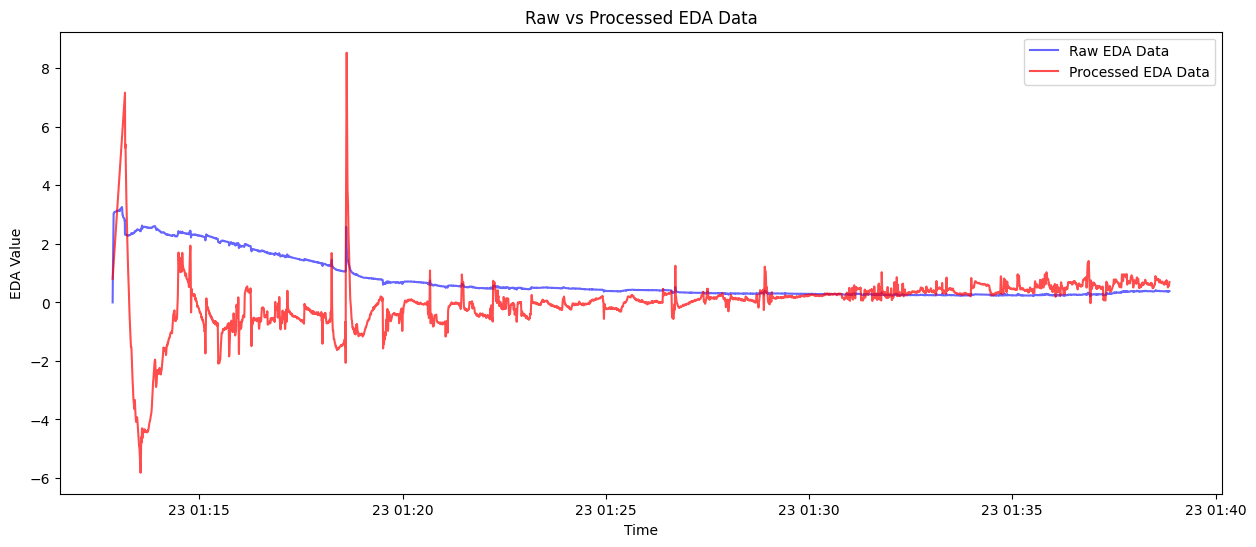

In [ ]:
# Plot Raw and Processed EDA Data
plt.figure(figsize=(15, 6))
plt.plot(eda_data['timestamp'], eda_values, label='Raw EDA Data', color='blue', alpha=0.6)
plt.plot(eda_data['timestamp'], eda_normalized, label='Processed EDA Data', color='red', alpha=0.7)
plt.title('Raw vs Processed EDA Data')
plt.xlabel('Time')
plt.ylabel('EDA Value')
plt.legend()
plt.show()

In [ ]:
# Trough-to-Peak Feature Extraction
def extract_trough_to_peak_features(eda_signal, fs):
    # Number of SCRs
    number_of_scrs = np.sum(eda_signal > np.mean(eda_signal) + 1 * np.std(eda_signal))
    summed_magnitude_of_scrs = np.sum(eda_signal[eda_signal > np.mean(eda_signal) + 1 * np.std(eda_signal)])
    summed_area_under_scrs = np.sum(eda_signal[eda_signal > np.mean(eda_signal) + 1 * np.std(eda_signal)])

    return {
        'Number_of_SCRs': number_of_scrs,
        'Summed_Magnitude_of_SCRs': summed_magnitude_of_scrs,
        'Summed_Area_Under_SCRs': summed_area_under_scrs
    }

In [ ]:
# Decomposition-Based Feature Extraction
def extract_decomposition_features(eda_signal):
    mean_tonic_level = np.mean(eda_signal)
    std_tonic_level = np.std(eda_signal)
    mean_phasic_activity = np.mean(np.diff(eda_signal))  # Using difference as a proxy for phasic
    number_of_responses = np.sum(np.diff(eda_signal) > 0)

    return {
        'Mean_Tonic_Level': mean_tonic_level,
        'Std_Tonic_Level': std_tonic_level,
        'Mean_Phasic_Activity': mean_phasic_activity,
        'Number_of_Responses': number_of_responses
    }

In [ ]:
# Additional Statistical Features
def extract_statistical_features(eda_signal):
    skewness = skew(eda_signal)
    kurtosis_value = kurtosis(eda_signal)

    return {
        'Skewness': skewness,
        'Kurtosis': kurtosis_value
    }

In [ ]:
# Segment the data into 5-second windows and extract features
window_size = 5 * fs  # 5 seconds worth of data

In [ ]:
features_list = []
for start in range(0, len(eda_normalized), window_size):
    end = start + window_size
    if end > len(eda_normalized):
        break
    window_eda = eda_normalized[start:end]
    features = {}
    features.update(extract_trough_to_peak_features(window_eda, fs))
    features.update(extract_decomposition_features(window_eda))
    features.update(extract_statistical_features(window_eda))
    features_list.append(features)

In [ ]:
# Convert to DataFrame
features_df = pd.DataFrame(features_list)


In [ ]:
# Load the synchronized data
sync_data = pd.read_csv('/content/sample_data/synchronized5_data.csv')

In [ ]:
# Start time for EDA data in milliseconds
start_time = 1548206905000
start_time = pd.to_datetime(start_time, unit='ms')

In [ ]:
# Calculate the timestamp for each 5-second interval
features_df['timestamp'] = pd.date_range(start=start_time, periods=len(features_df), freq='5S')


In [ ]:
# Convert timestamp to seconds since the start time
features_df['seconds'] = (features_df['timestamp'] - start_time).dt.total_seconds()

In [ ]:
# Synchronize the data based on the 'seconds' column
synchronized_data = pd.merge(features_df, sync_data, on='seconds', how='inner')

In [ ]:
# Save the final synchronized data
synchronized_data.to_csv('synchronized5_eda_features_final.csv', index=False)

In [ ]:
# Load the EDA data
eda_data = pd.read_csv('/content/sample_data/E4_EDA31.csv')
eda_data['timestamp'] = pd.to_datetime(eda_data['timestamp'], unit='ms')
eda_values = eda_data['value'].values

In [ ]:
# Define filter functions
def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_highpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def highpass_filter(data, cutoff, fs, order=4):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [ ]:
# Filtering
fs = 4  # Sampling frequency (4 Hz for EDA data)
low_cutoff = 1.0  # Low-pass filter cutoff frequency (Hz)
high_cutoff = 0.01  # High-pass filter cutoff frequency (Hz)

In [ ]:
eda_filtered = lowpass_filter(eda_values, low_cutoff, fs)
eda_filtered = highpass_filter(eda_filtered, high_cutoff, fs)

In [ ]:
# Detrending
eda_detrended = detrend(eda_filtered)

In [ ]:
# Detect and correct artifacts (sharp spikes)
def detect_and_correct_artifacts(eda_signal, threshold=3.0):
    # Calculate the Z-scores of the signal
    z_scores = zscore(eda_signal)

    # Identify where the Z-scores exceed the threshold (potential spikes)
    artifact_indices = np.where(np.abs(z_scores) > threshold)[0]

    # Correct artifacts by interpolating the values
    corrected_signal = eda_signal.copy()
    for index in artifact_indices:
        # Replace the artifact with the mean of neighboring points
        if 0 < index < len(eda_signal) - 1:
            corrected_signal[index] = (eda_signal[index - 1] + eda_signal[index + 1]) / 2

    return corrected_signal

In [ ]:
eda_corrected = detect_and_correct_artifacts(eda_detrended)

In [ ]:
# Z-Score Normalization
eda_normalized = (eda_corrected - np.mean(eda_corrected)) / np.std(eda_corrected)

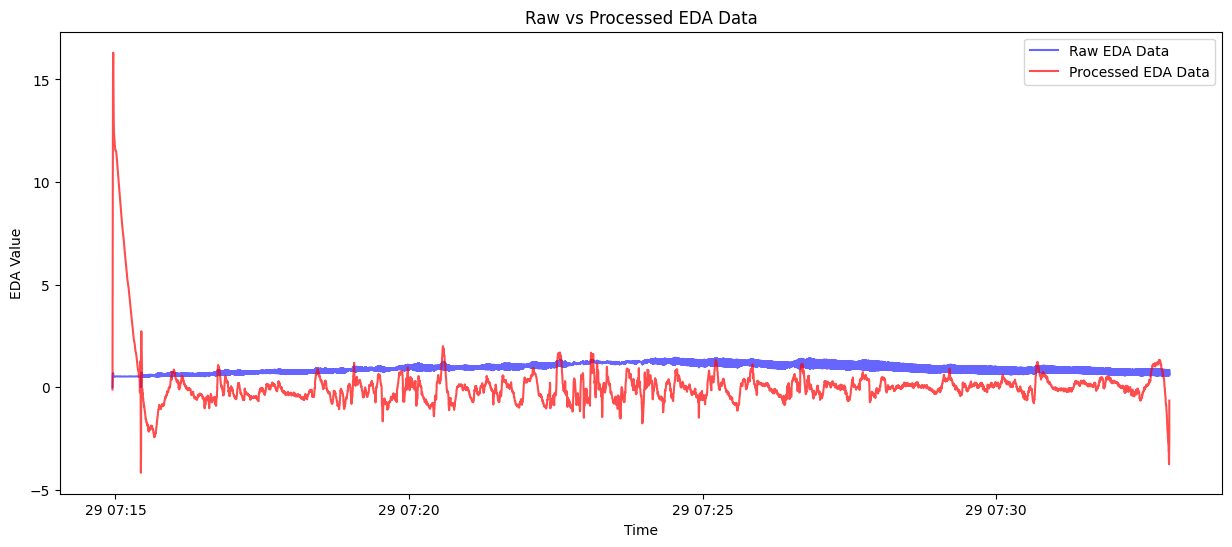

In [ ]:
# Plot Raw and Processed EDA Data
plt.figure(figsize=(15, 6))
plt.plot(eda_data['timestamp'], eda_values, label='Raw EDA Data', color='blue', alpha=0.6)
plt.plot(eda_data['timestamp'], eda_normalized, label='Processed EDA Data', color='red', alpha=0.7)
plt.title('Raw vs Processed EDA Data')
plt.xlabel('Time')
plt.ylabel('EDA Value')
plt.legend()
plt.show()

In [ ]:
# Trough-to-Peak Feature Extraction
def extract_trough_to_peak_features(eda_signal, fs):
    # Number of SCRs
    number_of_scrs = np.sum(eda_signal > np.mean(eda_signal) + 1 * np.std(eda_signal))
    summed_magnitude_of_scrs = np.sum(eda_signal[eda_signal > np.mean(eda_signal) + 1 * np.std(eda_signal)])
    summed_area_under_scrs = np.sum(eda_signal[eda_signal > np.mean(eda_signal) + 1 * np.std(eda_signal)])

    return {
        'Number_of_SCRs': number_of_scrs,
        'Summed_Magnitude_of_SCRs': summed_magnitude_of_scrs,
        'Summed_Area_Under_SCRs': summed_area_under_scrs
    }

In [ ]:
# Decomposition-Based Feature Extraction
def extract_decomposition_features(eda_signal):
    mean_tonic_level = np.mean(eda_signal)
    std_tonic_level = np.std(eda_signal)
    mean_phasic_activity = np.mean(np.diff(eda_signal))  # Using difference as a proxy for phasic
    number_of_responses = np.sum(np.diff(eda_signal) > 0)

    return {
        'Mean_Tonic_Level': mean_tonic_level,
        'Std_Tonic_Level': std_tonic_level,
        'Mean_Phasic_Activity': mean_phasic_activity,
        'Number_of_Responses': number_of_responses
    }

In [ ]:
# Additional Statistical Features
def extract_statistical_features(eda_signal):
    skewness = skew(eda_signal)
    kurtosis_value = kurtosis(eda_signal)

    return {
        'Skewness': skewness,
        'Kurtosis': kurtosis_value
    }

In [ ]:
# Segment the data into 5-second windows and extract features
window_size = 5 * fs  # 5 seconds worth of data

In [ ]:
features_list = []
for start in range(0, len(eda_normalized), window_size):
    end = start + window_size
    if end > len(eda_normalized):
        break
    window_eda = eda_normalized[start:end]
    features = {}
    features.update(extract_trough_to_peak_features(window_eda, fs))
    features.update(extract_decomposition_features(window_eda))
    features.update(extract_statistical_features(window_eda))
    features_list.append(features)

In [ ]:
# Convert to DataFrame
features_df = pd.DataFrame(features_list)

In [ ]:
# Load the synchronized data
sync_data = pd.read_csv('/content/sample_data/synchronized31_data.csv')

In [ ]:
# Start time for EDA data in milliseconds
start_time = 1553844121000
start_time = pd.to_datetime(start_time, unit='ms')

In [ ]:
# Calculate the timestamp for each 5-second interval
features_df['timestamp'] = pd.date_range(start=start_time, periods=len(features_df), freq='5S')

In [ ]:
# Convert timestamp to seconds since the start time
features_df['seconds'] = (features_df['timestamp'] - start_time).dt.total_seconds()

In [ ]:
# Synchronize the data based on the 'seconds' column
synchronized_data = pd.merge(features_df, sync_data, on='seconds', how='inner')

In [ ]:
# Save the final synchronized data
synchronized_data.to_csv('synchronized31_eda_features_final.csv', index=False)

# Heart Feature Extraction

In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 15.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import pywt

In [ ]:
# Load the HR data
hr_data = pd.read_csv('/content/sample_data/Polar_HR31.csv')

In [ ]:
def butter_lowpass_filter(data, cutoff, fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [ ]:
# Parameters for low-pass filter
cutoff = 0.4  # Cutoff frequency (Hz) for low-pass filtering
fs = 1.0  # Sampling frequency in Hz

In [ ]:
# Apply the low-pass filter to the heart rate data
hr_data['value_filtered'] = butter_lowpass_filter(hr_data['value'], cutoff, fs)

In [ ]:

def wavelet_denoise(data, wavelet='db4', level=1):
    coeffs = pywt.wavedec(data, wavelet, mode='symmetric')
    sigma = (1/0.6745) * np.median(np.abs(coeffs[-level] - np.median(coeffs[-level])))
    uthresh = sigma * np.sqrt(2 * np.log(len(data)))
    coeffs = [pywt.threshold(i, value=uthresh, mode='hard') for i in coeffs]
    denoised_data = pywt.waverec(coeffs, wavelet, mode='symmetric')

    # Ensure the denoised data matches the original length
    if len(denoised_data) > len(data):
        denoised_data = denoised_data[:len(data)]
    elif len(denoised_data) < len(data):
        denoised_data = np.pad(denoised_data, (0, len(data) - len(denoised_data)), 'edge')

    return denoised_data

In [ ]:
# Apply wavelet denoising to the filtered heart rate data
hr_data['value_denoised'] = wavelet_denoise(hr_data['value_filtered'])

In [ ]:
# Convert timestamp to seconds relative to the start time
start_time = 1553844121000
hr_data['seconds'] = (hr_data['timestamp'] - start_time) / 1000.0

In [ ]:
# Filter to only include data from the start time
hr_data_filtered = hr_data[hr_data['seconds'] >= 0].copy()

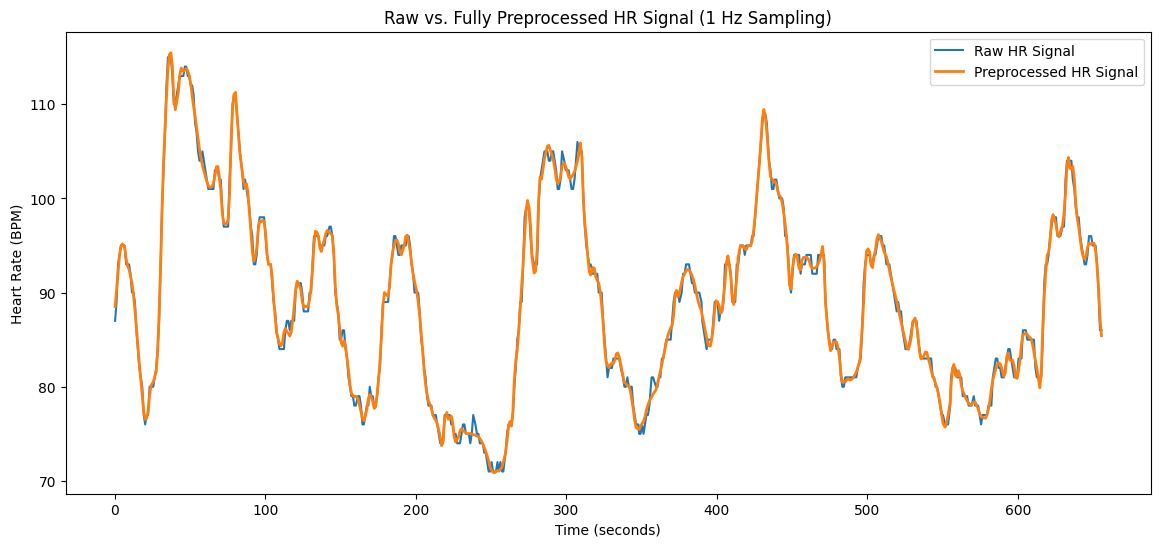

In [ ]:
# Plot the raw vs. preprocessed heart rate data
plt.figure(figsize=(14, 6))
plt.plot(hr_data_filtered['seconds'], hr_data_filtered['value'], label='Raw HR Signal')
plt.plot(hr_data_filtered['seconds'], hr_data_filtered['value_denoised'], label='Preprocessed HR Signal', linewidth=2)
plt.xlabel('Time (seconds)')
plt.ylabel('Heart Rate (BPM)')
plt.title('Raw vs. Fully Preprocessed HR Signal (1 Hz Sampling)')
plt.legend()
plt.show()

In [ ]:
# 1. Basic Descriptive Statistics
raw_mean = np.mean(hr_data['value'])
preprocessed_mean = np.mean(hr_data['value_denoised'])

raw_std = np.std(hr_data['value'])
preprocessed_std = np.std(hr_data['value_denoised'])

raw_range = np.ptp(hr_data['value'])  # Peak to peak (range)
preprocessed_range = np.ptp(hr_data['value_denoised'])

print("Descriptive Statistics:")
print(f"Raw Signal - Mean: {raw_mean}, Std Dev: {raw_std}, Range: {raw_range}")
print(f"Preprocessed Signal - Mean: {preprocessed_mean}, Std Dev: {preprocessed_std}, Range: {preprocessed_range}")

Descriptive Statistics:
Raw Signal - Mean: 89.5250255362615, Std Dev: 11.311367043221505, Range: 53.0
Preprocessed Signal - Mean: 89.52603447169668, Std Dev: 11.289793147140514, Range: 52.56386795366342


In [ ]:
def calculate_hrv_features(hr_values):
    rr_intervals = 60000 / hr_values
    diff_rr = np.diff(rr_intervals)

    avnn = np.mean(rr_intervals)
    cv = np.std(rr_intervals) / avnn if avnn != 0 else 0
    sdnn = np.std(rr_intervals)
    rmssd = np.sqrt(np.mean(diff_rr ** 2))
    sdsd = np.std(diff_rr)
    nn50 = np.sum(np.abs(diff_rr) > 50)
    pnn50 = nn50 / len(diff_rr) if len(diff_rr) > 0 else 0

    return pd.Series({
        'AVNN': avnn,
        'CV': cv,
        'SDNN': sdnn,
        'RMSSD': rmssd,
        'SDSD': sdsd,
        'NN50': nn50,
        'pNN50': pnn50
    })

In [ ]:
# Define window size (30 seconds) and step size (5 seconds)
window_size = 30  # Assuming 1 Hz data, this would be 30 seconds
step_size = 5  # Slide the window by 5 seconds

In [ ]:
# Extract HRV features using a rolling window
hrv_feature_list = []

In [ ]:
for start in range(0, len(hr_data_filtered) - window_size, step_size):
    end = start + window_size
    hr_values_window = hr_data_filtered['value_denoised'].iloc[start:end]

    # Calculate HRV features for this window
    hrv_features = calculate_hrv_features(hr_values_window)
    hrv_feature_list.append(hrv_features)

In [ ]:
# Convert the list of features to a DataFrame
hrv_feature_df = pd.DataFrame(hrv_feature_list)

In [ ]:
# Align the HRV features with the corresponding time in the HR data
hrv_feature_df['seconds'] = hr_data_filtered['seconds'].iloc[::step_size].values[:len(hrv_feature_df)]
hrv_feature_df['seconds'] = hrv_feature_df['seconds'].astype(int)  # Convert seconds to integer for merging

In [ ]:
# Load the P1.self data
p1_self_data = pd.read_csv('/content/sample_data/synchronized31_eda_features_final.csv')

In [ ]:
# Convert the 'seconds' column in both DataFrames to integer to ensure compatibility
hrv_feature_df['seconds'] = hrv_feature_df['seconds'].astype(int)
p1_self_data['seconds'] = p1_self_data['seconds'].astype(int)

In [ ]:
# Now perform the merge
merged_data = pd.merge_asof(p1_self_data, hrv_feature_df, on='seconds')

In [ ]:

# Drop NN50 and pNN50 if they are not useful
merged_data = merged_data.drop(columns=['NN50', 'pNN50'], errors='ignore')

In [ ]:
# Save or return the merged data for further analysis or model training
merged_data.to_csv('synchronized31_hrv_data.csv', index=False)

# **BVP** **FEATURE** **EXTRACTION**

In [ ]:
pip install antropy


In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, detrend, savgol_filter, welch
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
import antropy as ent
import matplotlib.pyplot as plt

In [ ]:
# Step 1: Load the data
bvp_data = pd.read_csv('/content/sample_data/E4_BVP31.csv')
sync_data = pd.read_csv('/content/sample_data/synchronized31_hrv_data.csv')

In [ ]:
# Define a butterworth filter function
def butter_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

In [ ]:
# Sampling frequency
fs = 64  # Assuming BVP data was sampled at 64 Hz

In [ ]:
# Apply bandpass filter (0.5 Hz to 5 Hz)
bvp_data['filtered'] = butter_filter(bvp_data['value'], lowcut=0.5, highcut=5, fs=fs, order=5)


In [ ]:
# Artifact Removal - Simple Thresholding
artifact_threshold = bvp_data['filtered'].mean() + 3 * bvp_data['filtered'].std()
bvp_data['artifact_removed'] = bvp_data['filtered']
bvp_data.loc[bvp_data['artifact_removed'] > artifact_threshold, 'artifact_removed'] = np.nan
bvp_data['artifact_removed'] = bvp_data['artifact_removed'].interpolate()

In [ ]:
# Apply Savitzky-Golay filter for smoothing
bvp_data['smoothed'] = savgol_filter(bvp_data['artifact_removed'], window_length=51, polyorder=3)

In [ ]:
# Z-Score Normalization
scaler = StandardScaler()
bvp_data['normalized'] = scaler.fit_transform(bvp_data[['smoothed']])

In [ ]:
# Check for any NaN or empty values after preprocessing
print("After preprocessing, check for NaN or empty values:")
print(bvp_data.isnull().sum())

After preprocessing, check for NaN or empty values:
timestamp           0
pid                 0
value               0
device_serial       0
device_number       0
entry_time          0
filtered            0
artifact_removed    0
smoothed            0
normalized          0
dtype: int64


In [ ]:
def extract_features(data, window_size, fs):
    features = []
    for i in range(0, len(data) - window_size, window_size):
        window = data[i:i + window_size]

        # Check if the window is empty or contains NaN values
        if len(window) == 0 or np.isnan(window).any():
            print(f"Skipping empty or NaN-containing window at index {i}")
            continue

        mean_val = np.mean(window)
        std_val = np.std(window)
        arc_length = np.sum(np.abs(np.diff(window)))
        skewness = skew(window)
        kurt = kurtosis(window)

        # Frequency-Domain Features
        f, Pxx = welch(window, fs=fs, nperseg=window_size)
        hf_psd = np.sum(Pxx[(f >= 0.15) & (f <= 0.4)])  # High frequency band (0.15-0.4 Hz)
        lf_psd = np.sum(Pxx[(f >= 0.04) & (f <= 0.15)])  # Low frequency band (0.04-0.15 Hz)
        rhf_psd = hf_psd / lf_psd if lf_psd != 0 else 0  # Handle division by zero

        # Entropy Features (using antropy)
        sampen = ent.sample_entropy(window, order=2)

        features.append([mean_val, std_val, arc_length, skewness, kurt, hf_psd, rhf_psd, sampen])

    # Convert the list of features into a DataFrame
    features_df = pd.DataFrame(features, columns=['Mean', 'Std_Dev', 'Arc_Length', 'Skewness', 'Kurtosis', 'HF_PSD', 'RHF_PSD', 'SampEn'])

    # Check if the feature DataFrame is empty
    print("Feature DataFrame head:")
    print(features_df.head())

    return features_df

In [ ]:
# Extract features with a window size corresponding to 5-second intervals
window_size = fs * 5
features_df = extract_features(bvp_data['normalized'].values, window_size, fs)


Feature DataFrame head:
       Mean   Std_Dev  Arc_Length  Skewness  Kurtosis     HF_PSD  RHF_PSD  \
0 -0.701099  4.385620   76.378503 -1.946464  3.991468  11.298130        0   
1 -0.304391  2.297189   50.616803 -0.954610  1.315840   0.976122        0   
2 -0.029581  1.254842   41.327307  0.143541 -1.067469   0.006409        0   
3  0.019044  1.076940   35.508366  0.086697 -1.367555   0.001958        0   
4  0.024922  0.903448   30.005975  0.077634 -1.421148   0.000448        0   

     SampEn  
0  0.162388  
1  0.292563  
2  0.372270  
3  0.334247  
4  0.311380  


In [ ]:
# Verify the feature extraction output
if features_df.empty:
    print("Warning: The features DataFrame is empty. No features were extracted.")

In [ ]:
# Define the start time for your BVP data in milliseconds
start_time = 1553844121000
start_time = pd.to_datetime(start_time, unit='ms')

In [ ]:
# Calculate the timestamp for each 5-second interval
features_df['timestamp'] = pd.date_range(start=start_time, periods=len(features_df), freq='5S')

In [ ]:
# Convert timestamp to seconds since the start time
features_df['seconds'] = (features_df['timestamp'] - start_time).dt.total_seconds()

In [ ]:
# Synchronize the features with the synchronized HRV data based on the 'seconds' column
synchronized_data = pd.merge(features_df, sync_data, on='seconds', how='inner')

In [ ]:
# Save the final synchronized data to a CSV file
synchronized_data.to_csv('synchronized31_bvp_features_final.csv', index=False)